In [1]:
#call libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

In [3]:
#call libraries
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize

In [4]:
#load the data
import os

os.getcwd()

os.chdir(r'C:\\Users\\he1108434\\Downloads')

excel_file = 'finding_2019.xlsx'
dataframe = pd.read_excel(excel_file)

In [5]:
dataframe.head()

,fertigungsdatum,schichtbezeichnung,heizunggruppebezeichnung,namelinie,bereich,fehlermenge,position_fehler,fehlercode,fehlergruppe,teilekategorie,fehler,analysedatenbemerkung,verursacherbezeichnung,analyseergebnisbezeichnung,ergebnis_linie
0,2019-12-18,C,HV 3G - RSA (Renault),Hochvolt EDH4,HV,1,NaN,J18a,Hochvolt,Heizungsgehäuse,Durchschlagfestigkeit Heizergehäuse,"15V /0,00411mA / Zu viel kleber seiltich;",BG Vorprüfung (HV ISO),Nacharbeit extern,nio
1,2019-12-18,F,HV 3G - HEW,Hochvolt EDH4,HV,1,NaN,J18a,Hochvolt,Heizungsgehäuse,Durchschlagfestigkeit Heizergehäuse,"2697V /0,1mA / Zu viel kleber seiltich;",BG Vorprüfung (HV ISO),Nacharbeit extern,nio
2,2019-12-18,F,HV 3G - HEW,Hochvolt EDH4,HV,1,NaN,J18a,Hochvolt,Heizungsgehäuse,Durchschlagfestigkeit Heizergehäuse,"2608V /0,3mA / iso Folie seitlich gerissen;",BG Vorprüfung (HV ISO),Nacharbeit extern,nio
3,2019-12-18,F,HV 3G - HEW,Hochvolt EDH4,HV,1,NaN,J18a,Hochvolt,Heizungsgehäuse,Durchschlagfestigkeit Heizergehäuse,"15V /4,1mA / iso Elektra unter Folie beschädigt;",BG Vorprüfung (HV ISO),Nacharbeit extern,nio
4,2019-12-18,F,HV 3G - Basis Heizer,Hochvolt EDH4,HV,1,NaN,J18a,Hochvolt,Heizungsgehäuse,Durchschlagfestigkeit Heizergehäuse,"1672V /0,3mA / Durchschlag an Kontaktblech oben;",BG Vorprüfung (HV ISO),Nacharbeit extern,nio


In [6]:
#create function to select most frequent words

def freq_words(text_data, terms):
    all_words = ' '.join([str(text) for text in text_data])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    #selecting top 20 most frequent words
    most_frequent_word = words_df.nlargest(columns='count', n=terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=most_frequent_word, x='word', y='count')
    ax.set(ylabel='Count')
    plt.show()

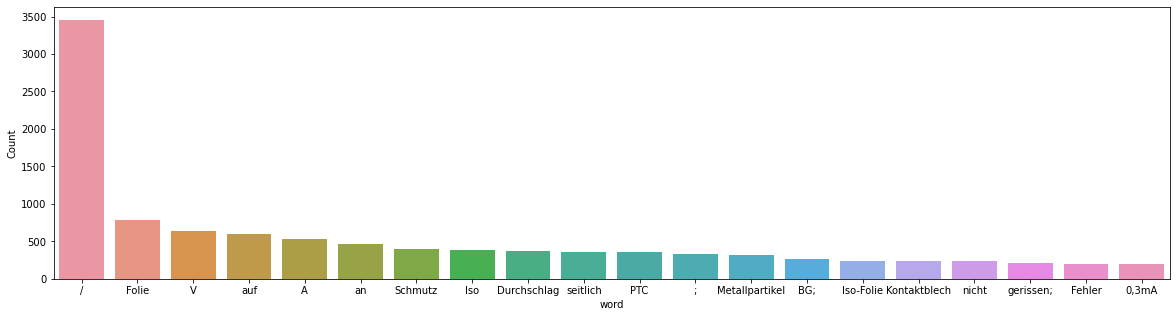

In [7]:
#raw data without cleaning

freq_words(dataframe['analysedatenbemerkung'], terms=20)

In [8]:
import copy

In [9]:
raw_docs = copy.deepcopy(dataframe['analysedatenbemerkung'])

In [10]:
raw_docs.head()

0           15V /0,00411mA / Zu viel kleber seiltich;
1             2697V /0,1mA / Zu viel kleber seiltich;
2         2608V /0,3mA / iso Folie seitlich gerissen;
3    15V /4,1mA / iso Elektra unter Folie beschädigt;
4    1672V /0,3mA / Durchschlag an Kontaktblech oben;
Name: analysedatenbemerkung, dtype: object

In [11]:
#remove punctuation

raw_docs = raw_docs.str.replace('[^\w\s]','')

<ipython-input-11-561cf8b797d6>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_docs = raw_docs.str.replace('[^\w\s]','')


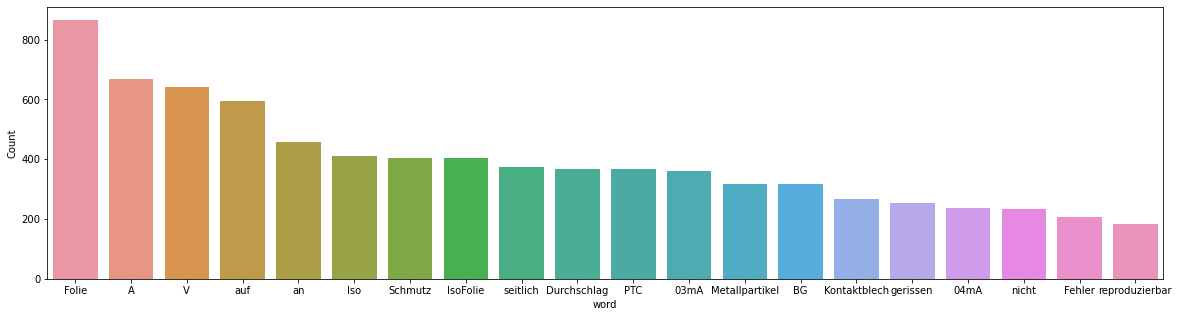

In [12]:
freq_words(raw_docs, terms=20)

In [13]:
#remove german stopwords

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

german_stop_words = stopwords.words('german')

In [14]:
def stop_word_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in german_stop_words])

raw_docs = raw_docs.apply(stop_word_removal)

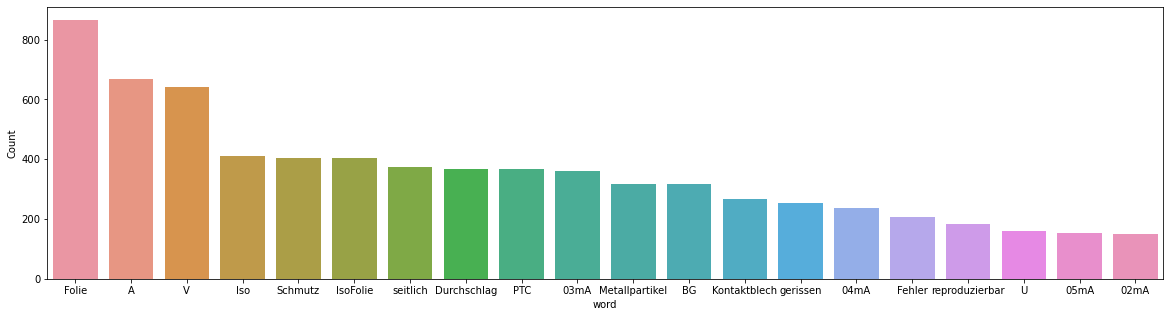

In [15]:
freq_words(raw_docs, terms=20)

In [16]:
#extract words based on vectorizer

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = count_vect.fit_transform(raw_docs.values.astype('U'))

In [17]:
doc_term_matrix

<2240x724 sparse matrix of type '<class 'numpy.int64'>'
	with 10441 stored elements in Compressed Sparse Row format>

In [18]:
#put into matrix composition

from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [19]:
#check random words

import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

1974
manueller
2217v
2478v
1910v
verschmiert
vorhanden
1334v
2456v
001ma


In [20]:
#call model

first_topic = LDA.components_[0]

In [21]:
top_topic_words = first_topic.argsort()[-10:]

In [22]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

keine
vorhanden
werte
04ma
03ma
oben
durchschlag
kontaktblech
reproduzierbar
fehler


In [23]:
#try to pull top ten words that frequently appear on the documents

for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['keine', 'vorhanden', 'werte', '04ma', '03ma', 'oben', 'durchschlag', 'kontaktblech', 'reproduzierbar', 'fehler']


Top 10 words for topic #1:
['nacharbeit', 'pos', 'hzg', 'riss', 'kontaktbleches', 'rand', 'folie', 'seitlich', 'kontaktblech', 'durchschlag']


Top 10 words for topic #2:
['05ma', 'beschädigt', 'versetzt', '04ma', '03ma', 'iso', 'gerissen', 'seitlich', 'isofolie', 'folie']


Top 10 words for topic #3:
['02ma', 'tasche', '04ma', 'metallpartikel', '03ma', 'vermutlich', 'isofolie', 'schmutz', 'bg', 'ptc']


Top 10 words for topic #4:
['eingerissen', 'rms', 'schon', 'durchschlag', 'irms', 'urms', 'schmutz', 'iso', 'metallpartikel', 'folie']


